<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fitting-a-Linear-Model-Using-Gradient-Descent" data-toc-modified-id="Fitting-a-Linear-Model-Using-Gradient-Descent-1">Fitting a Linear Model Using Gradient Descent</a></span></li><li><span><a href="#Derivative-of-the-MSE-cost" data-toc-modified-id="Derivative-of-the-MSE-cost-2">Derivative of the MSE cost</a></span></li><li><span><a href="#Running-Gradient-Descent" data-toc-modified-id="Running-Gradient-Descent-3">Running Gradient Descent</a></span></li></ul></div>

In [87]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
np.set_printoptions(precision=2)

In [88]:
# HIDDEN
tips = sns.load_dataset('tips')

In [89]:
# HIDDEN
def minimize(cost_fn, grad_cost_fn, x_vals, y_vals,
             alpha=0.0005, progress=True):
    '''
    Uses gradient descent to minimize cost_fn. Returns the minimizing value of
    theta once the cost changes less than 0.0001 between iterations.
    '''
    theta = np.array([0., 0.])
    cost = cost_fn(theta, x_vals, y_vals)
    while True:
        if progress:
            print(f'theta: {theta} | cost: {cost}')
        gradient = grad_cost_fn(theta, x_vals, y_vals)
        new_theta = theta - alpha * gradient
        new_cost = cost_fn(new_theta, x_vals, y_vals)
        
        if abs(new_cost - cost) < 0.0001:
            return new_theta
        
        theta = new_theta
        cost = new_cost

## Fitting a Linear Model Using Gradient Descent

We want to fit a linear model that predicts the tip amount based on the total bill of the table:

$$
f_\hat{\theta} (x) = \hat{\theta_1} x + \hat{\theta_0}
$$

In order to find $ \hat{\theta_1} $ and $ \hat{\theta_0} $, we need to first choose a cost function. We will choose the mean squared error cost function:

$$
\begin{aligned}
L(\hat{\theta}, x, y)
&= \frac{1}{n} \sum_{i = 1}^{n}(y_i - f_\hat{\theta} (x_i))^2\\
\end{aligned}
$$

Note that we have modified our loss function to reflect the addition of an explanatory variable in our new model. In this case, $ x $ is a vector containing the individual total bills, $ y $ is a vector containing the individual tip amounts, and $ \hat{\theta} $ is a vector: $ \theta = [ \hat{\theta_1}, \hat{\theta_0} ] $.

Using a linear model with the squared error also goes by the name of least-squares linear regression. We can use gradient descent to find the $ \theta $ that minimizes the cost.

**An Aside on Using Correlation**

If you have seen least-squares linear regression before, you may recognize that we can compute the correlation coefficient and use it to determine $ \hat{\theta_1} $ and $ \hat{\theta_0} $. This is simpler and faster to compute than using gradient descent for this specific problem, similar to how computing the mean was simpler than using gradient descent to fit a constant model. We will use gradient descent anyway because it is a general-purpose method of cost minimization that still works when we later introduce models that do not have analytic solutions. In fact, in many real-world scenarios we will use gradient descent even when an analytic solution exists, because the analytic solution is too computationally expensive to compute.

## Derivative of the MSE cost

In order to use gradient descent, we have to compute the derivative of the MSE cost with respect to $ \hat{\theta} $. Now that $ \hat{\theta} $ is a vector of length 2 instead of a scalar, $ \nabla_{\hat\theta} L(\hat{\theta}, x, y) $ will also be a vector of length 2.

$$
\begin{aligned}
\nabla_{\hat\theta} L(\hat{\theta}, x, y)
&= \nabla_{\hat\theta} \left[ \frac{1}{n} \sum_{i = 1}^{n}(y_i - f_\hat{\theta} (x_i))^2 \right] \\
&= \frac{1}{n} \sum_{i = 1}^{n}2 (y_i - f_\hat{\theta} (x_i))(- \nabla_{\hat\theta} f_\hat{\theta} (x_i))\\
&= -\frac{2}{n} \sum_{i = 1}^{n}(y_i - f_\hat{\theta} (x_i))(\nabla_{\hat\theta} f_\hat{\theta} (x_i))\\
\end{aligned}
$$

We know:

$$
f_\hat{\theta} (x) = \hat{\theta_1} x + \hat{\theta_0}
$$

We now need to compute $ \nabla_{\hat\theta} f_\hat{\theta} (x_i) $ which is a length 2 vector.

$$
\begin{aligned}
\nabla_{\hat\theta} f_\hat{\theta} (x_i)
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} f_\hat{\theta} (x_i)\\
     \frac{\partial}{\partial \theta_1} f_\hat{\theta} (x_i)
   \end{bmatrix} \\
&= \begin{bmatrix}
     \frac{\partial}{\partial \theta_0} [\hat{\theta_1} x_i + \hat{\theta_0}]\\
     \frac{\partial}{\partial \theta_1} [\hat{\theta_1} x_i + \hat{\theta_0}]
   \end{bmatrix} \\
&= \begin{bmatrix}
     1 \\
     x_i
   \end{bmatrix} \\
\end{aligned}
$$

Finally, we plug back into our formula above to get

$$
\begin{aligned}
\nabla_{\hat\theta} L(\hat{\theta}, x, y)
&= -\frac{2}{n} \sum_{i = 1}^{n}(y_i - f_\hat{\theta} (x_i))(\nabla_{\hat\theta} f_\hat{\theta} (x_i))\\
&= -\frac{2}{n} \sum_{i = 1}^{n} (y_i - f_\hat{\theta} (x_i)) \begin{bmatrix} 1 \\ x_i \end{bmatrix} \\
&= -\frac{2}{n} \sum_{i = 1}^{n} \begin{bmatrix}
    (y_i - f_\hat{\theta} (x_i)) \\
    (y_i - f_\hat{\theta} (x_i)) x_i
    \end{bmatrix} \\
\end{aligned}
$$

This is a length 2 vector since $ (y_i - f_\hat{\theta} (x_i)) $ is a scalar.

## Running Gradient Descent

Now, let's fit a linear model on the tips dataset to predict the tip amount from the total table bill. First, we define a Python function to compute the cost:

In [90]:
def simple_linear_model(thetas, x_vals):
    '''Returns predictions by a linear model on x_vals.'''
    return thetas[0] + thetas[1] * x_vals

def mse_cost(thetas, x_vals, y_vals):
    return np.mean((y_vals - simple_linear_model(thetas, x_vals)) ** 2)

Then, we define a function to compute the gradient of the cost:

In [91]:
def grad_mse_cost(thetas, x_vals, y_vals):
    n = len(x_vals)
    grad_0 = y_vals - simple_linear_model(thetas, x_vals)
    grad_1 = (y_vals - simple_linear_model(thetas, x_vals)) * x_vals
    return -2 / n * np.array([np.sum(grad_0), np.sum(grad_1)])

In [92]:
# HIDDEN
thetas = np.array([1, 1])
x_vals = np.array([3, 4])
y_vals = np.array([4, 5])
assert np.allclose(grad_mse_cost(thetas, x_vals, y_vals), [0, 0])

Finally, we run gradient descent!

In [93]:
%%time

thetas = minimize(mse_cost, grad_mse_cost, tips['total_bill'], tips['tip'])

theta: [ 0.  0.] | cost: 10.896283606557377
theta: [ 0.    0.07] | cost: 3.8937622006094705
theta: [ 0.   0.1] | cost: 1.9359443267168215
theta: [ 0.01  0.12] | cost: 1.388538448286097
theta: [ 0.01  0.13] | cost: 1.235459416905535
theta: [ 0.01  0.14] | cost: 1.1926273731479433
theta: [ 0.01  0.14] | cost: 1.1806184944517062
theta: [ 0.01  0.14] | cost: 1.177227251696266
theta: [ 0.01  0.14] | cost: 1.1762453624313751
theta: [ 0.01  0.14] | cost: 1.1759370980989148
theta: [ 0.01  0.14] | cost: 1.175817178966766
CPU times: user 57.7 ms, sys: 14.1 ms, total: 71.8 ms
Wall time: 76.9 ms


Using our estimated thetas, we can plot our predictions with the scatter plot of tip vs. total bill.

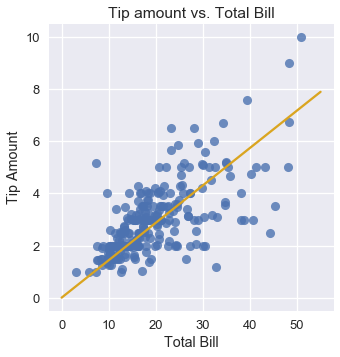

In [94]:
# HIDDEN
x_vals = np.array([0, 55])
sns.lmplot(x='total_bill', y='tip', data=tips, fit_reg=False)
plt.plot(x_vals, simple_linear_model(thetas, x_vals), c='goldenrod')
plt.title('Tip amount vs. Total Bill')
plt.xlabel('Total Bill')
plt.ylabel('Tip Amount');

We can see that if a table's bill is \$10, our model will predict that the waiter gets around \$1.50 in tip. Similarly, if a table's bill is \$40, our model will predict a tip of around \$6.00.